<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v15_gradientNorms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v15: Gradient Norms
Firstly, my latest literature survey has found that it's very common to use the frobenius norm of gradient tensors to measure their magnitude. Secondly, I've since realised that when collecting stats per-epoch, I need to compute the _mean_ or _sum_ of gradients over the entire epoch, rather than blindly picking the latest value.

Together, that could produce far smoother and more meaningful results when plotting 1) per-epoch stats, 2) model-wide stats of magnitudes (per-epoch or per-step), and 3) comparing layer magnitudes.

**[UPDATE 2025-02-28]**: I've since also found out that while RMS is mathematically equivalent to a size-normalized norm, RMS is considerably more efficient to calculation. It does have slightly different numerical stability behaviours, with no obvious choice over which is better.

Furthermore, I've since changed the code to default to computing the mean of layer outputs and layer output gradients over all samples when running in per-epoch mode. This was necessary because the last batch of each epoch often has less samples than for all other batches. This also changes the gradient capture and norm calculations for layer outputs.

Thus, I need to revise the tests and verify the results again with those revisions in place.

In [90]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout cefc7cc
#!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at d150eb8 Locked to git revision
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 14 (delta 8), reused 10 (delta 6), pack-reused 0 (from 0)
Unpacking objects: 100% (14/14), 3.41 MiB | 4.33 MiB/s, done.
From https://github.com/malcolmlett/ml-learning
   d150eb8..dc27bf3  main       -> origin/main
Updating d150eb8..dc27bf3
Fast-forward
 Learning_visualisations_v15_gradientNorms.ipynb | 628 +++++++++++++++++++++++++++++++++++++-------
 train_observability_toolkit.py                  | 118 +++------
 2 files changed, 569 insertions(+), 177 deletions(-)


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [91]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [92]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basics


In [93]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

class TimingCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self._start = None
    self._epochs = None
    self.total = None
    self.per_epoch = None

  def on_epoch_begin(self, epoch, logs=None):
    if epoch == 1:
      self._start = tf.timestamp()
    self._epochs = epoch-1

  def on_train_end(self, logs=None):
    self.total = (tf.timestamp() - self._start).numpy()
    self.per_epoch = self.total / (self._epochs)

# Basic accumulation strategy
First, we'll start with a basic data collection routine to confirm how we can most efficiently aggregate sum or mean values over the course of an epoch.

In [101]:
# Timings CPU - on binary classification model:
#  - 45ms - baseline
#  - 65ms - naive accumulator = accumalotor + value, with minimal pre-initialisation, no @tf.function
#  - 65ms - naive accumulator = accumalotor + value, with minimal pre-initialisation, with @tf.function
#  - 77ms - tf.Variable accumulator with pre-initialisation, no @tf.function
#  - 77ms - tf.Variable accumulator with pre-initialisation, with @tf.function
# Timings GPU - on MNIST classification model (32000 samples, batch-size 64):
#  - 3700ms (5.5ms/step) - baseline
#  - 4700ms (7.0ms/step) - naive accumulator = accumalotor + value, with minimal pre-initialisation, without @tf.function
#  - 5400ms (6.8ms/step) - naive accumulator = accumalotor + value, with minimal pre-initialisation, with @tf.function
#  - 5400ms (7.2ms/step) - tf.Variable accumulator with pre-initialisation, without @tf.function
#  - 3770ms (6.5ms/step) - tf.Variable accumulator with pre-initialisation, with @tf.function
#  - note: the supplied gradients are GPU-bound. So are the TF value and tf.Variable() accumulators.
class MyCallback1(tot.BaseGradientCallback):
  def __init__(self):
    super().__init__()
    self._accumulators = None
    self._norms = []  # list (by iteration) of list (by variable) of scalar norms of gradients

  @property
  def norms(self):
    return np.stack(self._norms, axis=0)

  def on_epoch_begin(self, epoch):
    if self._accumulators is not None:
      self._accumulators = [None] * len(self._accumulators)

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    self._norms.append([tf.norm(tensor)/tf.sqrt(tf.cast(tf.size(tensor), dtype=tensor.dtype)) if tensor is not None else None for tensor in self._accumulators])

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    self._init_accumulators(gradients)
    self._accumulators = self._accumulate(self._accumulators, gradients)

  def _init_accumulators(self, gradients):
    if self._accumulators is None:
      self._accumulators = [None] * len(gradients)

  @tf.function
  def _accumulate(self, accumulators, values):
    res = []
    for accumulator, value in zip(accumulators, values):
      if value is not None:
        if accumulator is None:
          accumulator = value
        else:
          accumulator += value
      else:
        accumulator = None
      res.append(accumulator)
    return res

class MyCallback2(tot.BaseGradientCallback):
  def __init__(self):
    super().__init__()
    self._accumulators = None
    self._norms = []  # list (by iteration) of list (by variable) of scalar norms of gradients
    self._steps = None

  @property
  def norms(self):
    return np.stack(self._norms, axis=0)

  def on_epoch_begin(self, epoch):
    if self._accumulators is not None:
      for a in self._accumulators:
        a.assign(tf.zeros(a.shape))

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    scale = tf.cast(self._steps, dtype=tf.float32)
    self._norms.append([tf.norm(tensor/scale)/tf.sqrt(tf.cast(tf.size(tensor), dtype=tensor.dtype)) if tensor is not None else None for tensor in self._accumulators])

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    # init
    if self._accumulators is None:
      self._accumulators = [tf.Variable(tf.zeros_like(g), dtype=g.dtype) for g in gradients]

    # accumulate
    self._accumulate(self._accumulators, gradients)
    self._steps = batch

  @tf.function
  def _accumulate(self, accumulators, values):
    for accumulator, value in zip(accumulators, values):
      if value is not None:
        accumulator.assign_add(value)

reload(tot)
tf.config.run_functions_eagerly(False)

cb = MyCallback1()
timing = TimingCallback()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(), cb, timing])
duration = (tf.timestamp() - start).numpy()
print(f"Total training time: {duration:.2f} secs. Average: {timing.per_epoch*1000:.2f}ms/epoch")

# cb = MyCallback1()
# timing = TimingCallback()
# model = mnist_cnn_model()
# train_X, train_Y = mnist_dataset()
# dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(32000).batch(64)
# start = tf.timestamp()
# history = tot.fit(model, dataset, epochs=10, callbacks=[tot.HistoryStats(), cb , timing])
# duration = (tf.timestamp() - start).numpy()
# print(f"Total training time: {duration:.2f} secs. Average: {timing.per_epoch*1000:.2f}ms/epoch")

Epoch    10 - 342.50ms/epoch: accuracy: 0.7467  binary_crossentropy: 0.5000  loss: 0.5000  mse: 0.1644  
Epoch    20 - 89.06ms/epoch: accuracy: 0.8300  binary_crossentropy: 0.3728  loss: 0.3728  mse: 0.1178  
Epoch    30 - 78.36ms/epoch: accuracy: 0.8500  binary_crossentropy: 0.3460  loss: 0.3460  mse: 0.1089  
Epoch    40 - 81.41ms/epoch: accuracy: 0.8433  binary_crossentropy: 0.3153  loss: 0.3153  mse: 0.0999  
Epoch    50 - 82.58ms/epoch: accuracy: 0.9067  binary_crossentropy: 0.2304  loss: 0.2304  mse: 0.0689  
Epoch    60 - 72.46ms/epoch: accuracy: 0.8733  binary_crossentropy: 0.2796  loss: 0.2796  mse: 0.0878  
Epoch    70 - 71.58ms/epoch: accuracy: 0.9100  binary_crossentropy: 0.2237  loss: 0.2237  mse: 0.0688  
Epoch    80 - 81.80ms/epoch: accuracy: 0.9233  binary_crossentropy: 0.1841  loss: 0.1841  mse: 0.0551  
Epoch    90 - 89.96ms/epoch: accuracy: 0.9233  binary_crossentropy: 0.1832  loss: 0.1832  mse: 0.0540  
Epoch   100 - 131.62ms/epoch: accuracy: 0.9333  binary_crossent

In [102]:
cb.norms.shape

(100, 16)

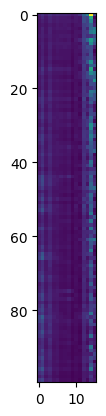

In [103]:
plt.imshow(cb.norms)

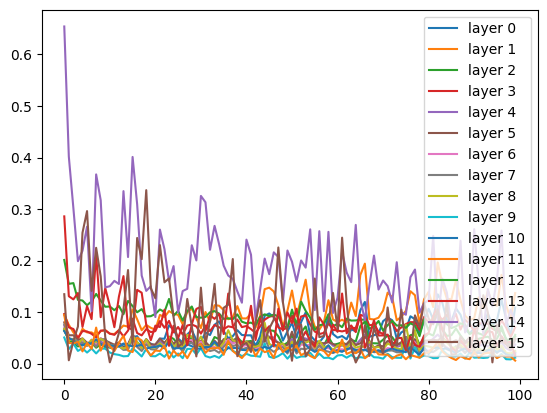

In [104]:
for c in range(cb.norms.shape[1]):
  plt.plot(cb.norms[:,c], label=f"layer {c}")
plt.legend()
#plt.yscale('log')
plt.show()

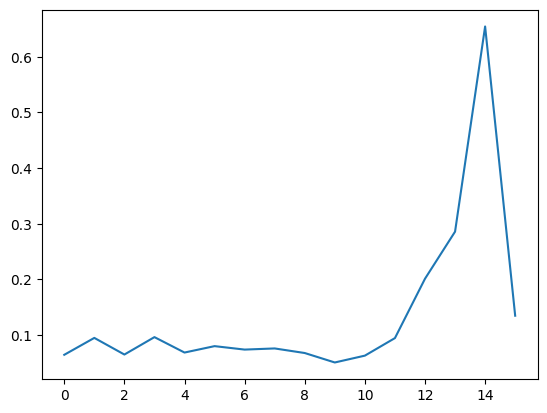

In [106]:
plt.plot(cb.norms[0,:])

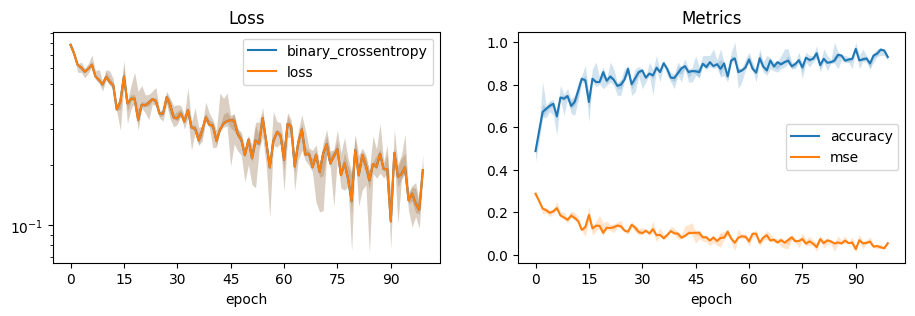

In [105]:
tot.plot_train_history(history)

## Size-normalized Norms vs RMS
For more experiments on this, including performance comparison, see "v16 Implicit Learning Rate".

In [107]:
# Notice:
#  - norm varies with tensor size, which is why I prefer to use a size-normalized version when comparing layers
#  - norm(a)/sqrt(size(a)) == rms(a)
#  - I have seen some examples wher the values differ a little (see v16 notebook), but none here.
tf.random.set_seed(36)

a = tf.random.normal((256,))
norm = tf.norm(a)
size_normalized_norm = tf.norm(a) / tf.sqrt(tf.cast(tf.size(a), dtype=a.dtype))
rms = tf.sqrt(tf.reduce_mean(tf.square(a)))
print(f"norm: {norm}, size_normalized_norm: {size_normalized_norm}, rms: {rms}")

a = tf.random.normal((100, 256))
norm = tf.norm(a)
size_normalized_norm = tf.norm(a) / tf.sqrt(tf.cast(tf.size(a), dtype=a.dtype))
rms = tf.sqrt(tf.reduce_mean(tf.square(a)))
print(f"norm: {norm}, size_normalized_norm: {size_normalized_norm}, rms: {rms}")

a = tf.random.normal((1000, 2560))
norm = tf.norm(a)
size_normalized_norm = tf.norm(a) / tf.sqrt(tf.cast(tf.size(a), dtype=a.dtype))
rms = tf.sqrt(tf.reduce_mean(tf.square(a)))
print(f"norm: {norm}, size_normalized_norm: {size_normalized_norm}, rms: {rms}")

norm: 15.890870094299316, size_normalized_norm: 0.9931793808937073, rms: 0.9931793808937073
norm: 159.7267608642578, size_normalized_norm: 0.9982922673225403, rms: 0.9982922673225403
norm: 1598.6741943359375, size_normalized_norm: 0.9991713762283325, rms: 0.9991713166236877


## Revised standard observability results
Now update the observability toolkit and run against the basic classification dataset to compare results.

Reference results:
* see: `Learning_visualisations_v13.ipynb` - "Learning Visualisations v13: Extending all callbacks for value stats, magnitude stats, and activity stats, plus a new HistoryStats callback"

In [133]:
reload(tot)
tf.config.run_functions_eagerly(False)

variables = tot.VariableHistoryCallback(per_step=True, collection_sets=[{}])
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=[{}])
outputs = tot.LayerOutputHistoryCallback(per_step=True, collection_sets=[{}])
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=[{}])

epoch_gradients = tot.GradientHistoryCallback(per_step=False, collection_sets=[{}])
epoch_outputs = tot.LayerOutputHistoryCallback(per_step=False, collection_sets=[{}])
epoch_output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=False, collection_sets=[{}])

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[
    tot.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients, epoch_gradients, epoch_outputs, epoch_output_gradients, tot.HistoryStats(per_step=True)])

Epoch     1 - 11.12s/epoch: accuracy: 0.4700  binary_crossentropy: 0.9201  loss: 0.9201  mse: 0.3247  
Epoch     2 - 4.18s/epoch: accuracy: 0.5367  binary_crossentropy: 0.7892  loss: 0.7892  mse: 0.2769  
Epoch     3 - 566.74ms/epoch: accuracy: 0.6400  binary_crossentropy: 0.6469  loss: 0.6469  mse: 0.2275  
Epoch     4 - 554.91ms/epoch: accuracy: 0.6533  binary_crossentropy: 0.6313  loss: 0.6313  mse: 0.2219  
Epoch     5 - 534.87ms/epoch: accuracy: 0.6400  binary_crossentropy: 0.6464  loss: 0.6464  mse: 0.2259  
Epoch     6 - 1.67s/epoch: accuracy: 0.7367  binary_crossentropy: 0.5625  loss: 0.5625  mse: 0.1903  
Epoch     7 - 535.19ms/epoch: accuracy: 0.7400  binary_crossentropy: 0.5681  loss: 0.5681  mse: 0.1898  
Epoch     8 - 646.69ms/epoch: accuracy: 0.7633  binary_crossentropy: 0.5478  loss: 0.5478  mse: 0.1845  
Epoch     9 - 591.87ms/epoch: accuracy: 0.6833  binary_crossentropy: 0.6124  loss: 0.6124  mse: 0.2088  
Epoch    10 - 593.25ms/epoch: accuracy: 0.7500  binary_crossent

In [134]:
# verify that per-epoch variable gradients are correctly aggregated over each step
batch_count = int(len(gradients.steps) / len(epoch_gradients.epochs))
print(f"epochs:      {len(epoch_gradients.epochs)}")
print(f"batch_count: {batch_count}")
print(f"variables:   {len(model.variables)}")
err_found = False
for epoch in range(len(epoch_gradients.epochs)):
  for v_idx in range(len(model.variables)):
    if model.variables[v_idx].trainable:
      it_start = epoch * batch_count
      it_end = (epoch+1) * batch_count
      batch_grads = np.stack(gradients.gradients[v_idx][it_start:it_end], axis=0)
      pred_epoch_grads = np.sum(batch_grads, axis=0)
      batch_grad_norm = tf.norm(pred_epoch_grads)

      epoch_grads = epoch_gradients.gradients[v_idx][epoch]
      epoch_norm = tf.norm(epoch_grads)

      if not np.allclose(pred_epoch_grads, epoch_grads):
        err_found = True
        err = np.sqrt(np.mean((pred_epoch_grads - epoch_grads)**2))
        print(f"  [epoch {epoch}, variable {v_idx}]: err: {err} <- batch_grads: {batch_grads.shape}, epoch_grads: {epoch_grads.shape}, norms: {batch_grad_norm} vs {epoch_norm}")
if not err_found:
  print(f"All epoch variable gradients match sum of per-step gradients")

epochs:      10
batch_count: 10
variables:   20
All epoch variable gradients match sum of per-step gradients


In [135]:
# verify that per-epoch outputs are correctly aggregated over each step
batch_count = int(len(outputs.steps) / len(epoch_outputs.epochs))
batch_size = max([out.shape[0] for out in outputs.layer_outputs[0]])
min_batch_size = min([out.shape[0] for out in outputs.layer_outputs[0]])
sample_count = batch_size * (batch_count-1) + min_batch_size
print(f"epochs:       {len(epoch_outputs.epochs)}")
print(f"sample_count: {sample_count}")
print(f"batch_count:  {batch_count}")
print(f"batch_size:   {batch_size}, and {min_batch_size} for last batch of each epoch")
print(f"layers:       {len(model.layers)}")
err_found = False
for epoch in range(len(epoch_outputs.epochs)):
  for l_idx in range(len(model.layers)):
    if outputs.layer_outputs[l_idx] is not None:
      it_start = epoch * batch_count
      it_end = (epoch+1) * batch_count
      batch_outs0 = outputs.layer_outputs[l_idx][it_start]
      batch_outsB = outputs.layer_outputs[l_idx][it_end-1]
      pred_epoch_outs = [np.sum(out, axis=0) for out in outputs.layer_outputs[l_idx][it_start:it_end]]
      pred_epoch_outs = np.sum(pred_epoch_outs, axis=0) / sample_count
      batch_norm = tf.norm(pred_epoch_outs)

      epoch_outs = epoch_outputs.layer_outputs[l_idx][epoch]
      epoch_norm = tf.norm(epoch_outs)

      if not np.allclose(pred_epoch_outs, epoch_outs):
        err_found = True
        err = np.sqrt(np.mean((pred_epoch_outs - epoch_outs)**2))
        print(f"  [epoch {epoch}, layer {l_idx}]: err: {err} <- batch_outputs: {batch_outs0.shape}..{batch_outsB.shape}, epoch_outputs: {epoch_outs.shape}, norms: {batch_norm} vs {epoch_norm}")
if not err_found:
  print(f"All epoch output gradients match mean of per-sample gradients")

epochs:       10
sample_count: 300
batch_count:  10
batch_size:   32, and 12 for last batch of each epoch
layers:       10
All epoch output gradients match mean of per-sample gradients


In [136]:
# verify that per-epoch output gradients are correctly aggregated over each step
batch_count = int(len(output_gradients.steps) / len(epoch_output_gradients.epochs))
batch_size = max([out.shape[0] for out in output_gradients.gradients[0]])
min_batch_size = min([out.shape[0] for out in output_gradients.gradients[0]])
sample_count = batch_size * (batch_count-1) + min_batch_size
print(f"epochs:       {len(epoch_output_gradients.epochs)}")
print(f"sample_count: {sample_count}")
print(f"batch_count:  {batch_count}")
print(f"batch_size:   {batch_size}, and {min_batch_size} for last batch of each epoch")
print(f"layers:       {len(model.layers)}")
err_found = False
for epoch in range(len(epoch_output_gradients.epochs)):
  for l_idx in range(len(model.layers)):
    if output_gradients.gradients[l_idx] is not None:
      it_start = epoch * batch_count
      it_end = (epoch+1) * batch_count
      batch_grads0 = output_gradients.gradients[l_idx][it_start]
      batch_gradsB = output_gradients.gradients[l_idx][it_end-1]
      pred_epoch_grads = [np.sum(out, axis=0) for out in output_gradients.gradients[l_idx][it_start:it_end]]
      pred_epoch_grads = np.sum(pred_epoch_grads, axis=0) / sample_count
      batch_norm = tf.norm(pred_epoch_grads)

      epoch_grads = epoch_output_gradients.gradients[l_idx][epoch]
      epoch_norm = tf.norm(epoch_grads)

      if not np.allclose(pred_epoch_grads, epoch_grads):
        err_found = True
        err = np.sqrt(np.mean((pred_epoch_grads - epoch_grads)**2))
        print(f"  [epoch {epoch}, layer {l_idx}]: err: {err} <- batch_grads: {batch_grads0.shape}..{batch_gradsB.shape}, epoch_grads: {epoch_grads.shape}, norms: {batch_norm} vs {epoch_norm}")
if not err_found:
  print(f"All epoch output gradients match mean of per-sample gradients")

epochs:       10
sample_count: 300
batch_count:  10
batch_size:   32, and 12 for last batch of each epoch
layers:       10
All epoch output gradients match mean of per-sample gradients


In [137]:
# verify that gradient norms are what we'd expect if computing manually
batch_count = int(len(gradients.steps) / len(epoch_gradients.epochs))
print(f"epochs:      {len(epoch_gradients.epochs)}")
print(f"steps:       {len(gradients.steps)}")
print(f"variables:   {len(model.variables)}")

err_found = False
for step in range(len(gradients.steps)):
  for v_idx in range(len(model.variables)):
    if model.variables[v_idx].trainable:
      norm = gradients.value_norms[v_idx][step]
      raw_grads = gradients.gradients[v_idx][step]
      raw_grad_norm = tf.sqrt(tf.reduce_mean(tf.square(raw_grads)))

      if not np.allclose(norm, raw_grad_norm):
        err_found = True
        err = norm - raw_grad_norm
        print(f"  [step {step}, variable {v_idx}]: err: {err} <- raw grads: {raw_grads.shape}, raw grad norm: {raw_grad_norm}, collected norm: {norm}")
if not err_found:
  print(f"All per-step gradient norms match expected values")

err_found = False
for epoch in range(len(epoch_gradients.epochs)):
  for v_idx in range(len(model.variables)):
    if model.variables[v_idx].trainable:
      norm = epoch_gradients.value_norms[v_idx][epoch]
      raw_grads = epoch_gradients.gradients[v_idx][epoch]
      raw_grad_norm = tf.sqrt(tf.reduce_mean(tf.square(raw_grads)))

      if not np.allclose(norm, raw_grad_norm):
        err_found = True
        err = norm - raw_grad_norm
        print(f"  [epoch {epoch}, variable {v_idx}]: err: {err} <- raw grads: {raw_grads.shape}, raw grad norm: {raw_grad_norm}, collected norm: {norm}")
if not err_found:
  print(f"All per-epoch gradient norms match expected values")

epochs:      10
steps:       100
variables:   20
All per-step gradient norms match expected values
All per-epoch gradient norms match expected values


In [138]:
# verify that layer output gradient norms are what we'd expect if computing manually
batch_count = int(len(output_gradients.steps) / len(epoch_output_gradients.epochs))
print(f"epochs:      {len(epoch_output_gradients.epochs)}")
print(f"steps:       {len(output_gradients.steps)}")
print(f"layers:      {len(model.layers)}")
print(f"example step  gradients: {output_gradients.gradients[0][0].shape}")
print(f"example epoch gradients: {epoch_output_gradients.gradients[0][0].shape}")

err_found = False
for step in range(len(output_gradients.steps)):
  for l_idx in range(len(model.layers)):
    if output_gradients.gradients[l_idx] is not None:
      norm = output_gradients.value_norms[l_idx][step]
      raw_grads = output_gradients.gradients[l_idx][step]
      raw_grad_norm = tf.sqrt(tf.reduce_mean(tf.square(raw_grads)))

      if not np.allclose(norm, raw_grad_norm):
        err_found = True
        err = norm - raw_grad_norm
        print(f"  [step {step}, layer {l_idx}]: err: {err} <- raw grads: {raw_grads.shape}, raw grad norm: {raw_grad_norm}, collected norm: {norm}")
if not err_found:
  print(f"All per-step output gradient norms match expected values")

err_found = False
for epoch in range(len(epoch_output_gradients.epochs)):
  for l_idx in range(len(model.layers)):
    if epoch_output_gradients.gradients[l_idx] is not None:
      norm = epoch_output_gradients.value_norms[l_idx][epoch]
      raw_grads = epoch_output_gradients.gradients[l_idx][epoch]
      raw_grad_norm = tf.sqrt(tf.reduce_mean(tf.square(raw_grads)))

      if not np.allclose(norm, raw_grad_norm):
        err_found = True
        err = norm - raw_grad_norm
        print(f"  [epoch {epoch}, layer {l_idx}]: err: {err} <- raw grads: {raw_grads.shape}, raw grad norm: {raw_grad_norm}, collected norm: {norm}")
if not err_found:
  print(f"All per-epoch output gradient norms match expected values")

epochs:      10
steps:       100
layers:      10
example step  gradients: (32, 100)
example epoch gradients: (100,)
All per-step output gradient norms match expected values
All per-epoch output gradient norms match expected values


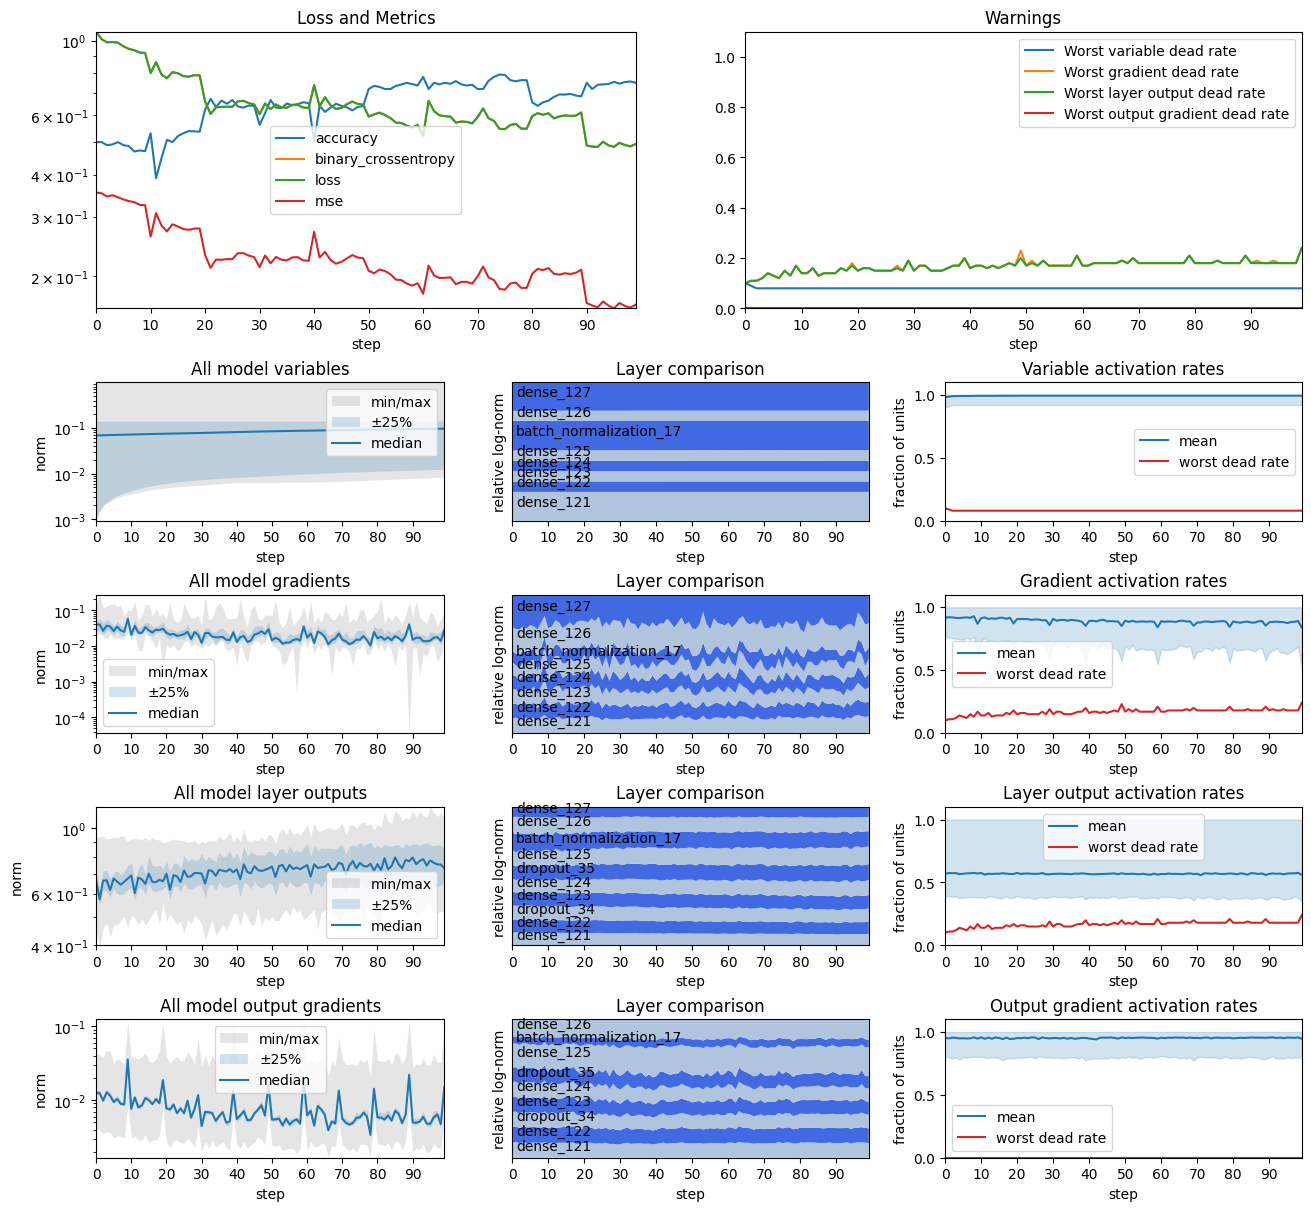

In [139]:
tot.plot_history_overview(callbacks=[history, variables, gradients, outputs, output_gradients])

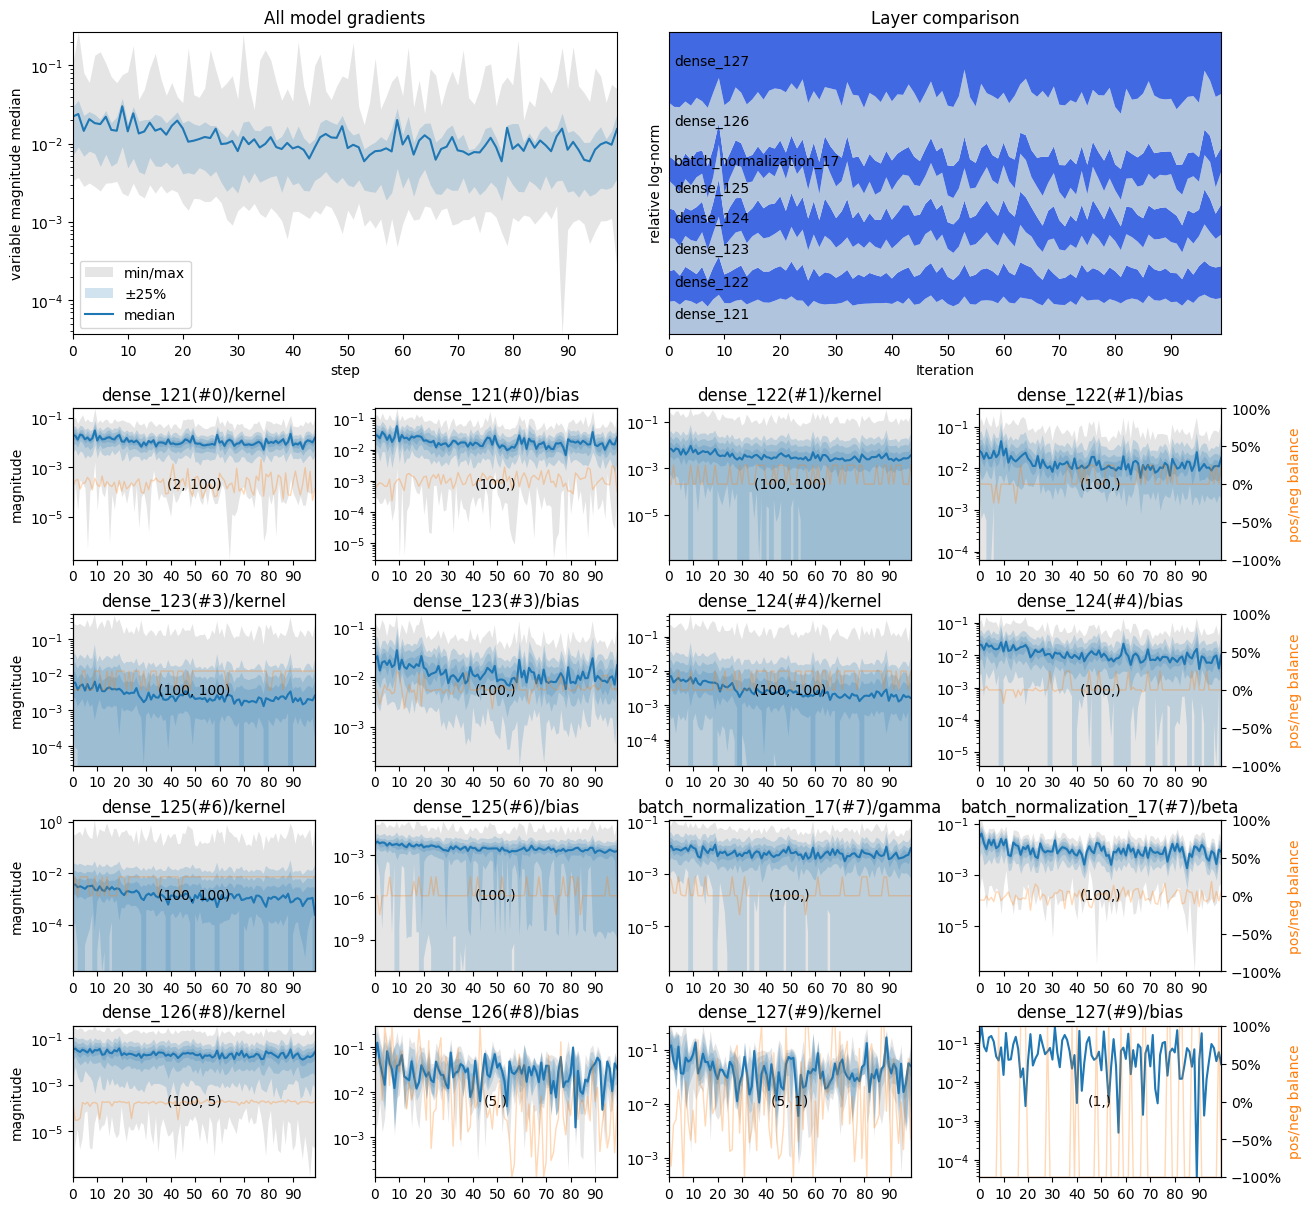

In [140]:
tot.plot_value_history(gradients, show='magnitudes')

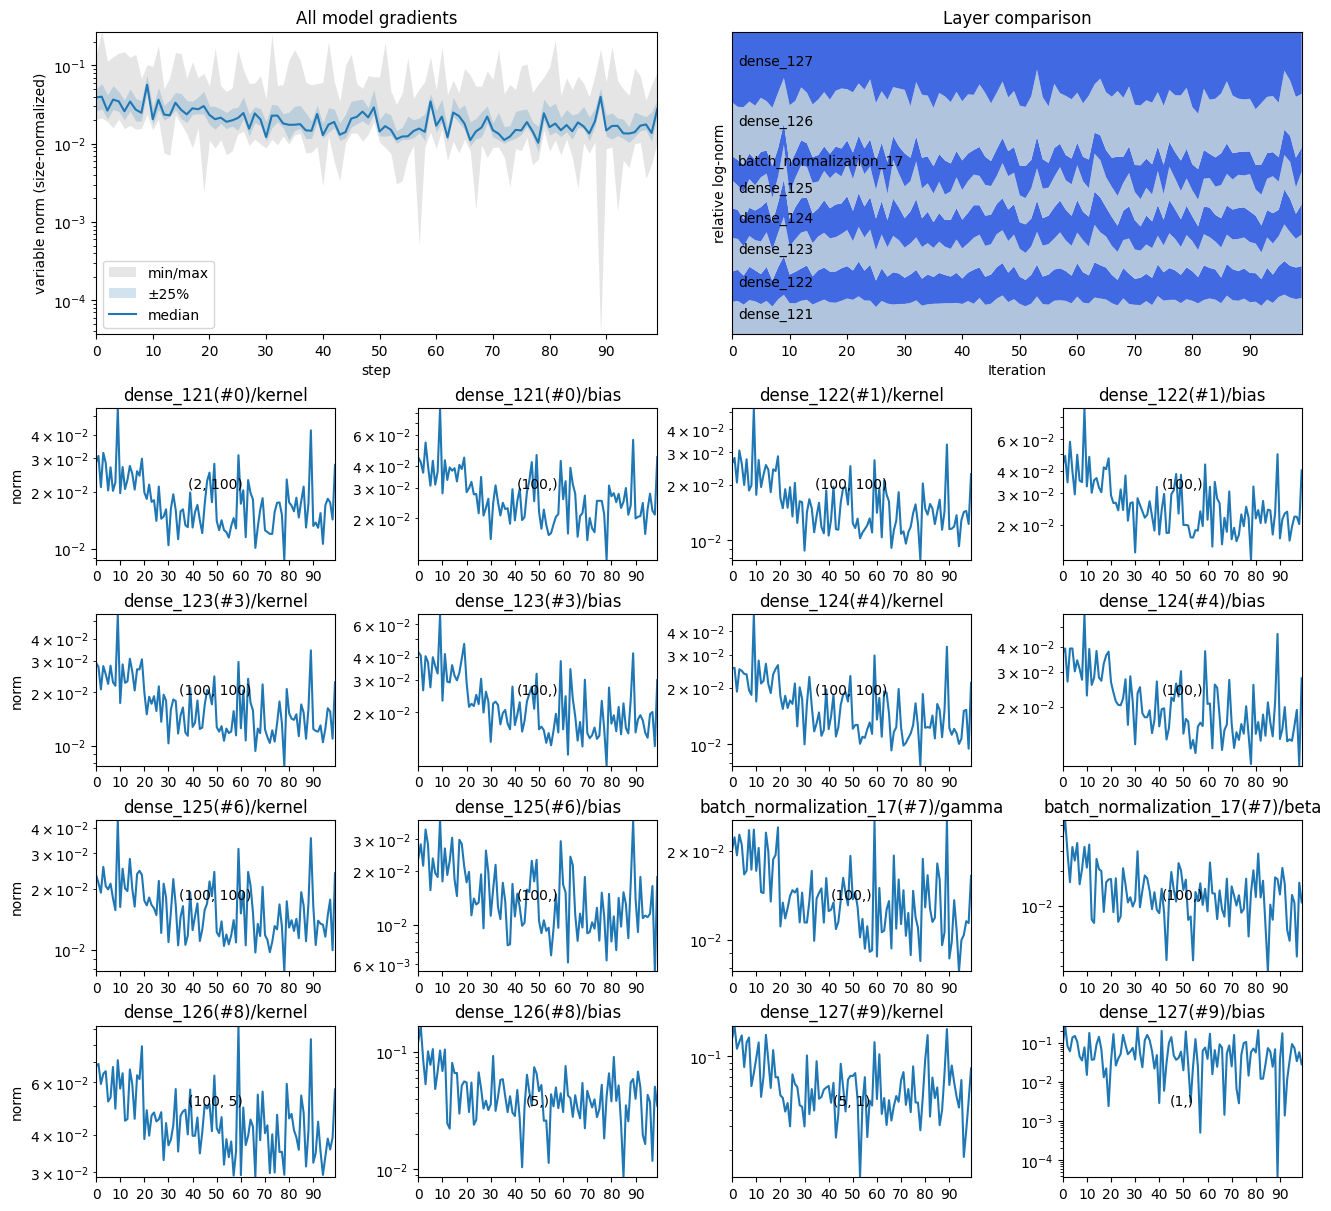

In [141]:
tot.plot_value_history(gradients, show='norms')

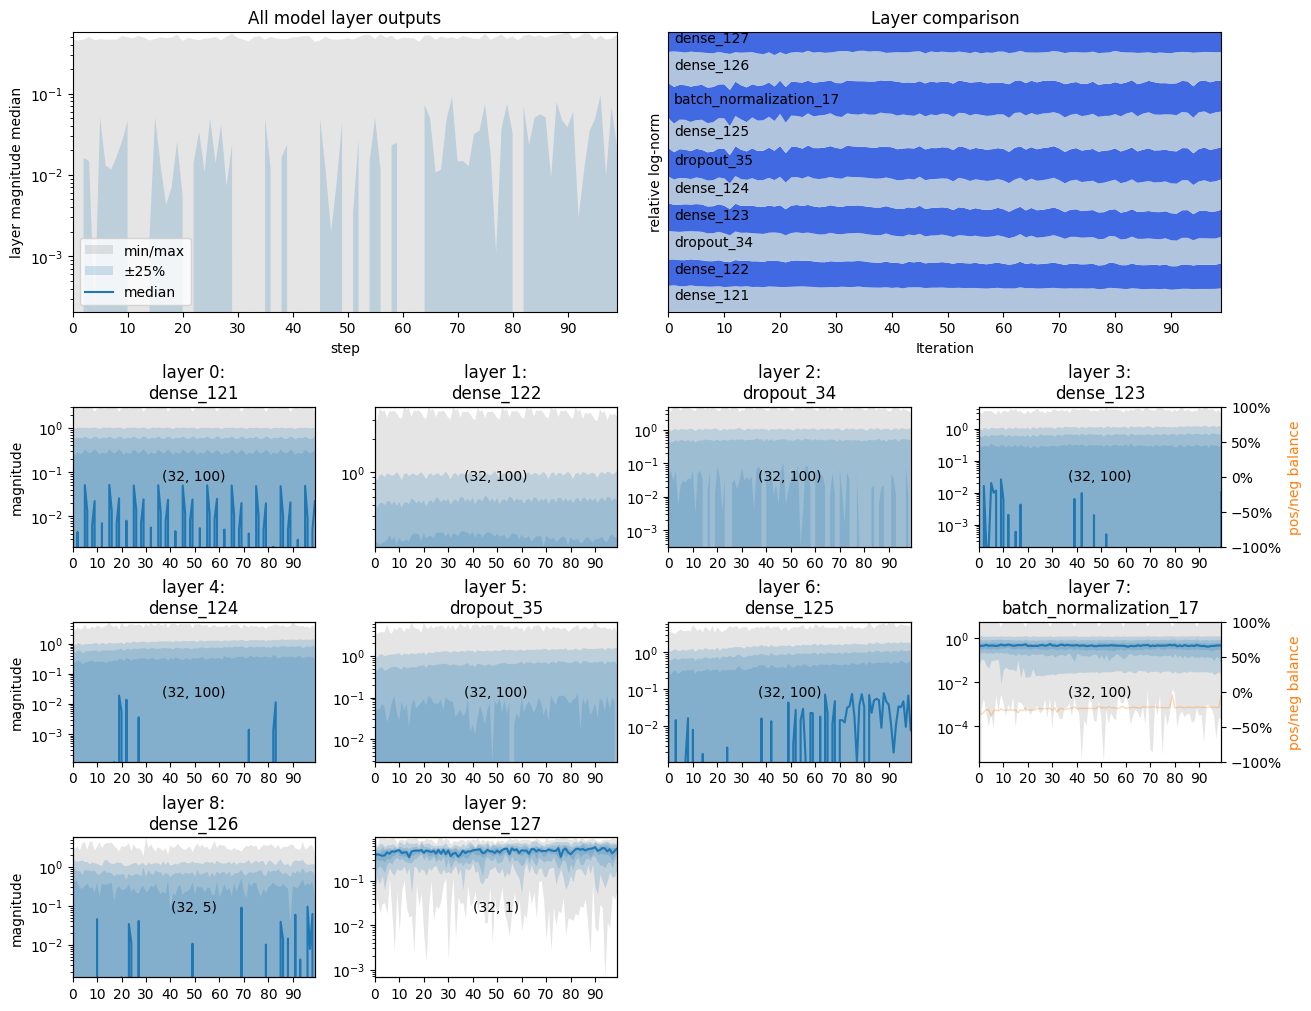

In [142]:
tot.plot_value_history(outputs, show='magnitudes')

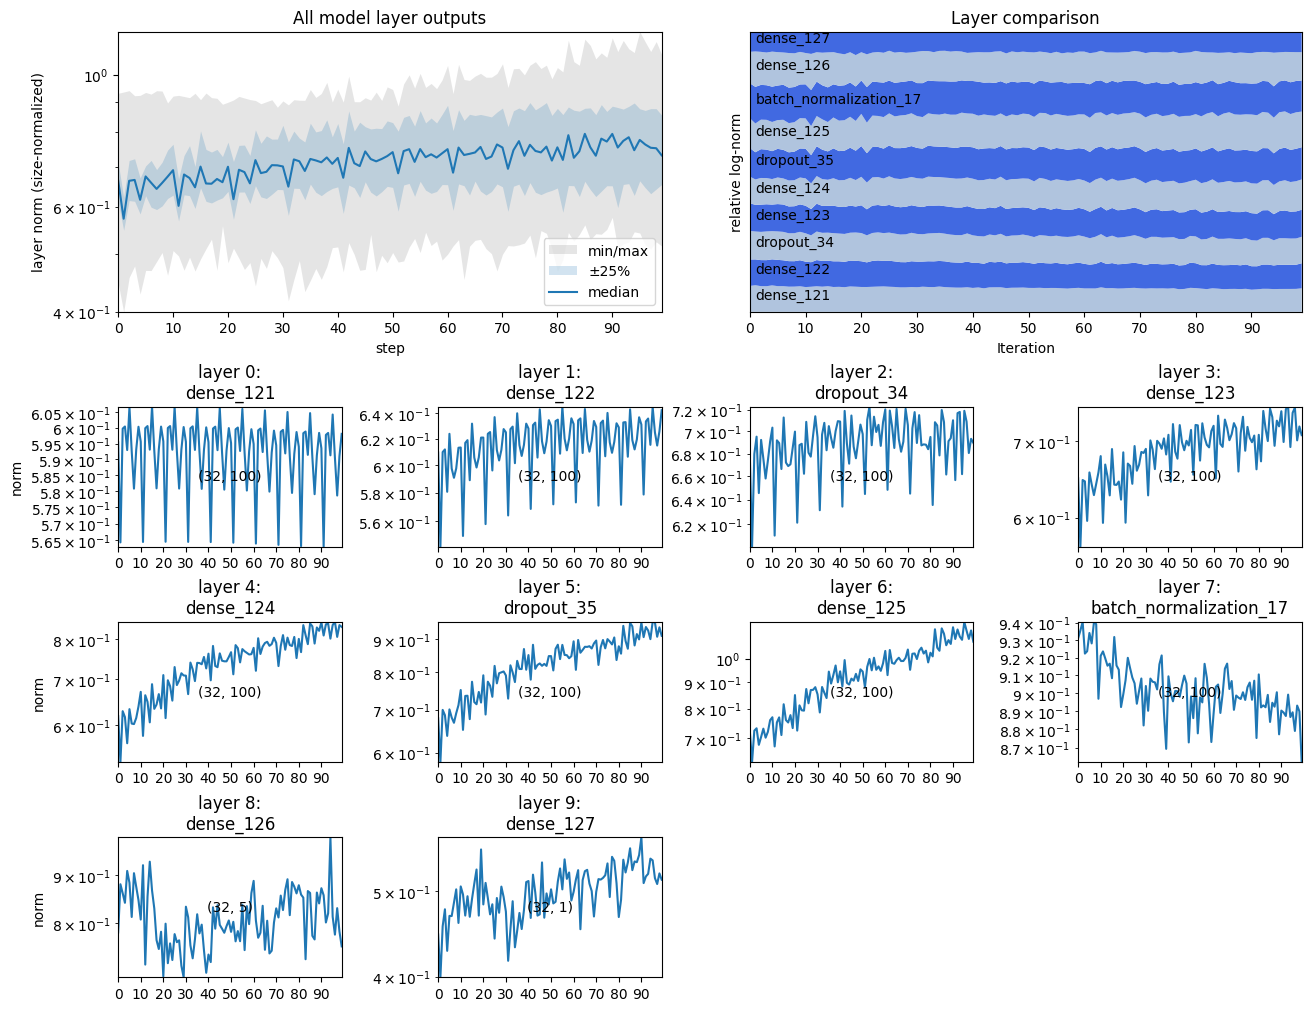

In [143]:
tot.plot_value_history(outputs, show='norms')

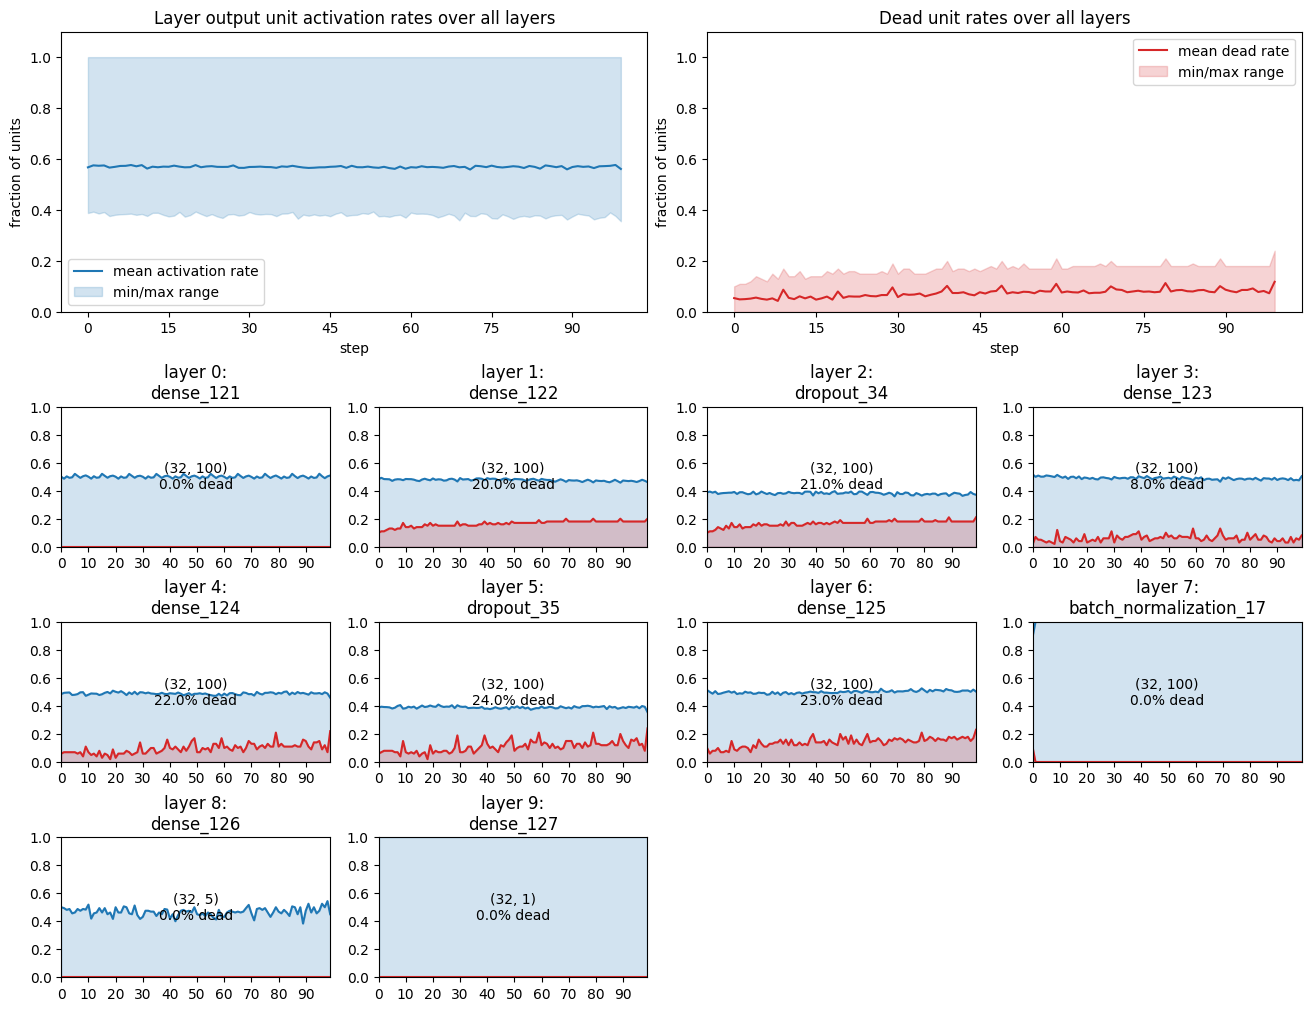

In [144]:
tot.plot_activity_history(outputs)

## Per-epoch plots

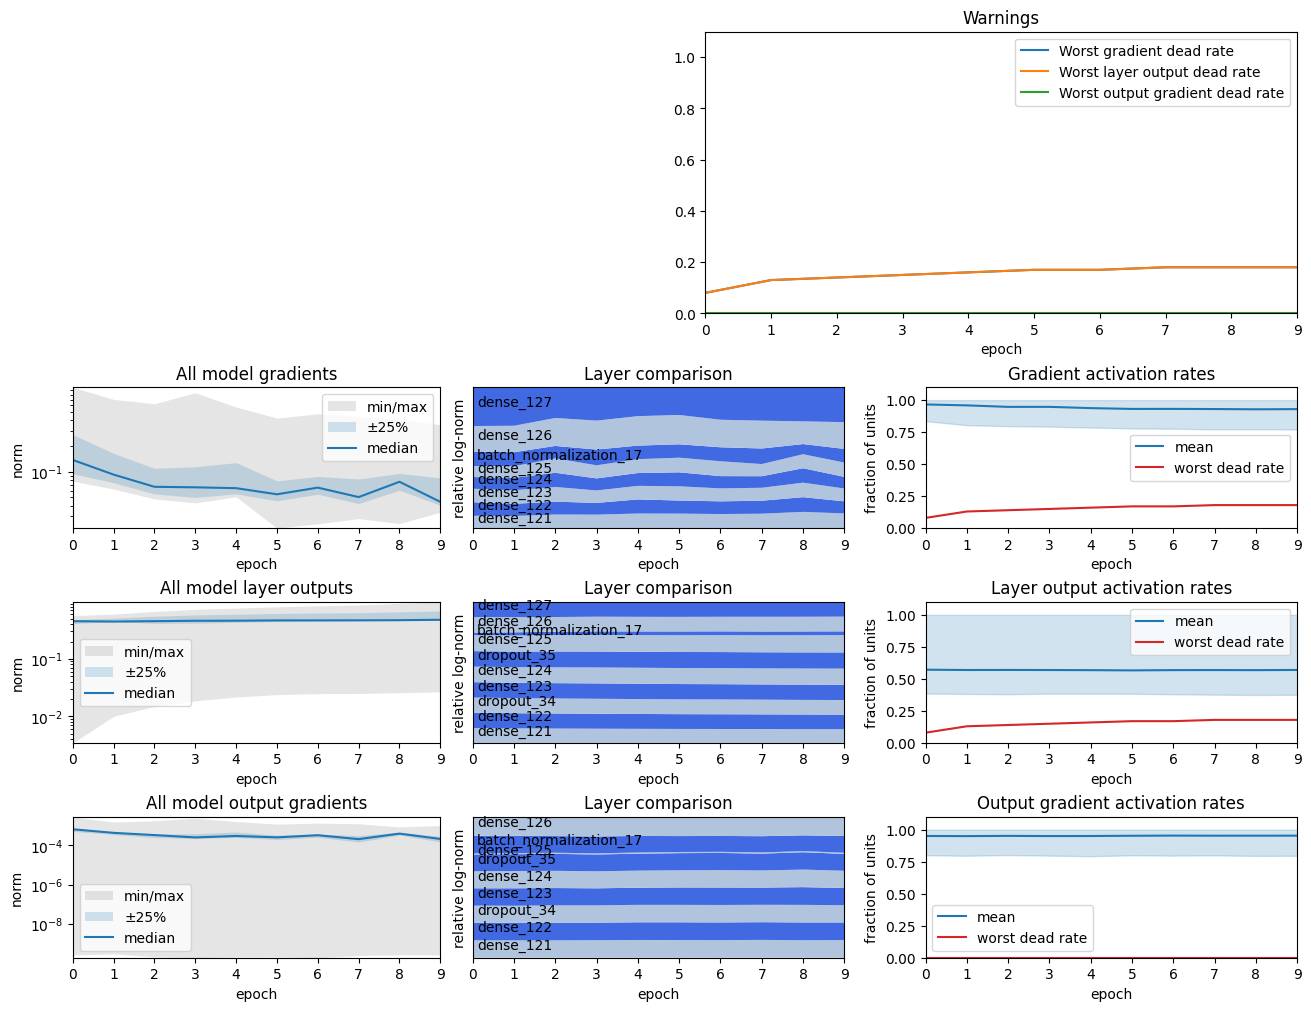

In [145]:
tot.plot_history_overview(callbacks=[epoch_gradients, epoch_outputs, epoch_output_gradients])

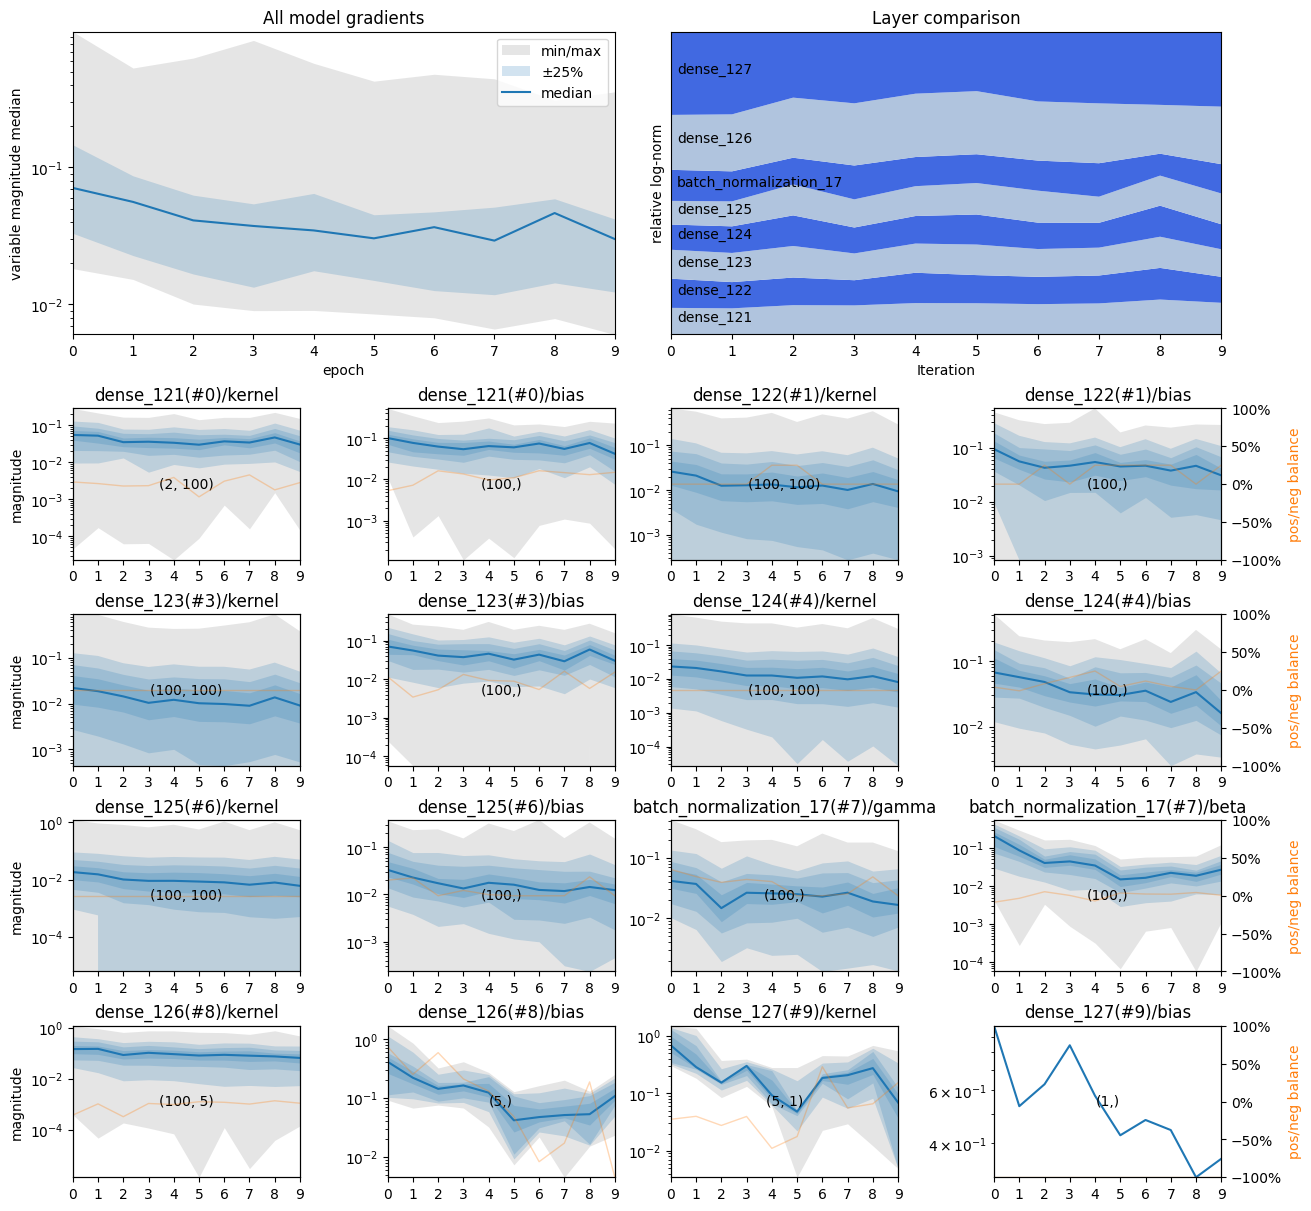

In [146]:
tot.plot_value_history(epoch_gradients, show='magnitudes')

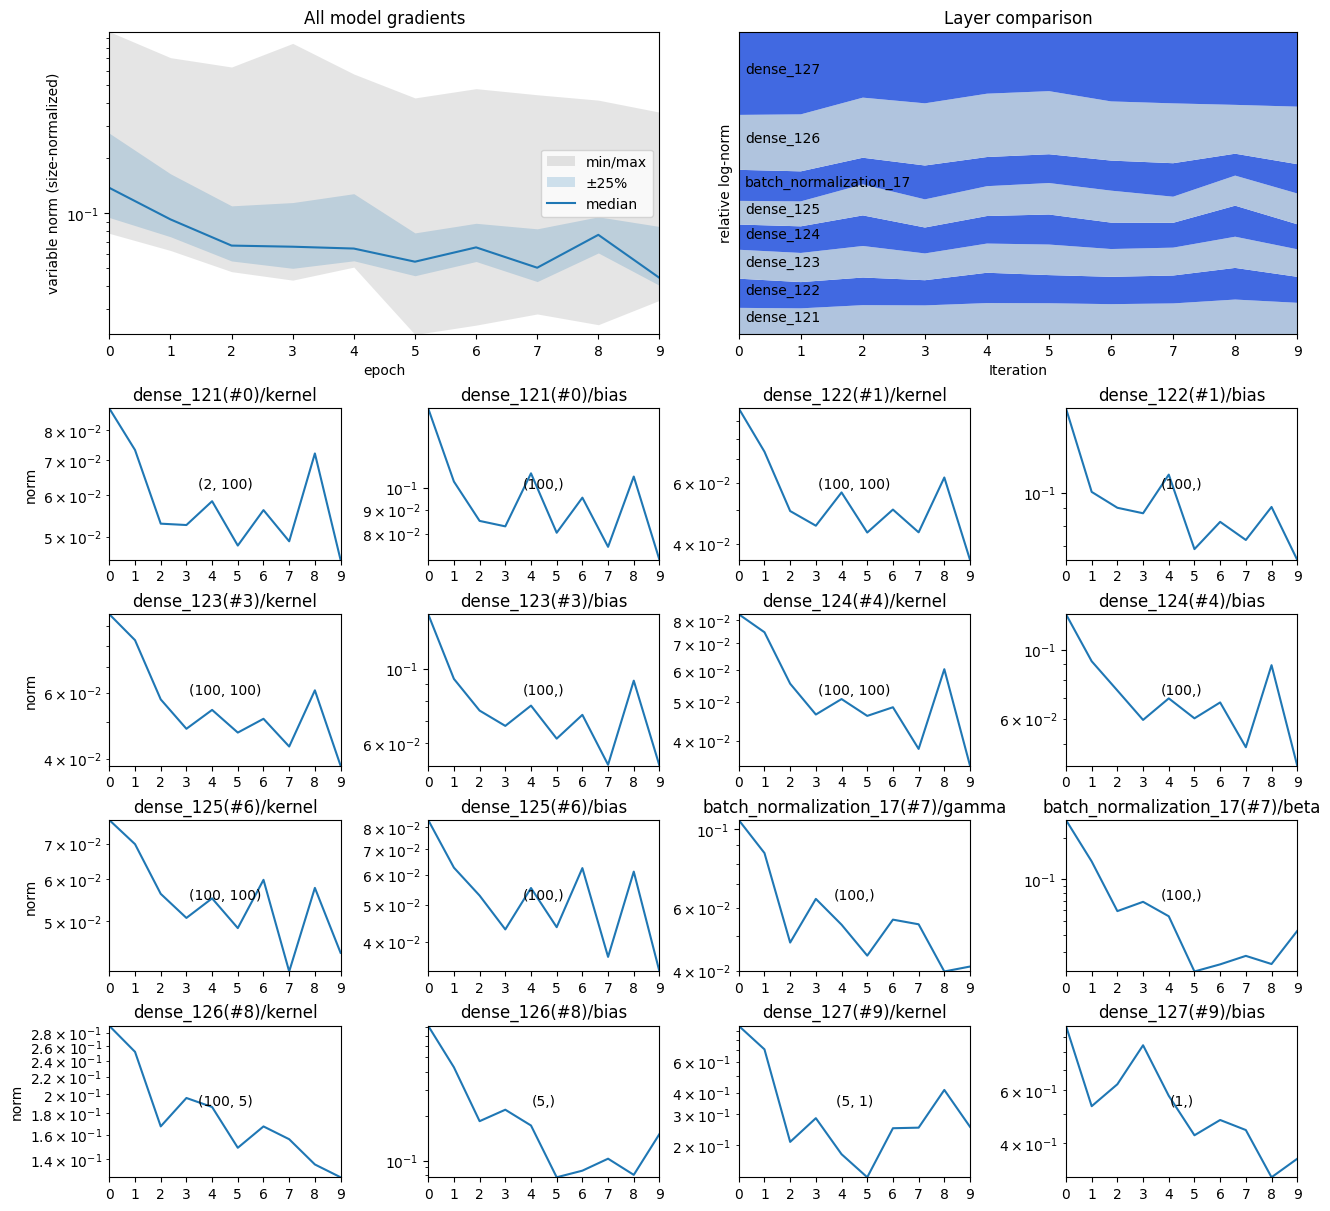

In [149]:
tot.plot_value_history(epoch_gradients, show='norms')

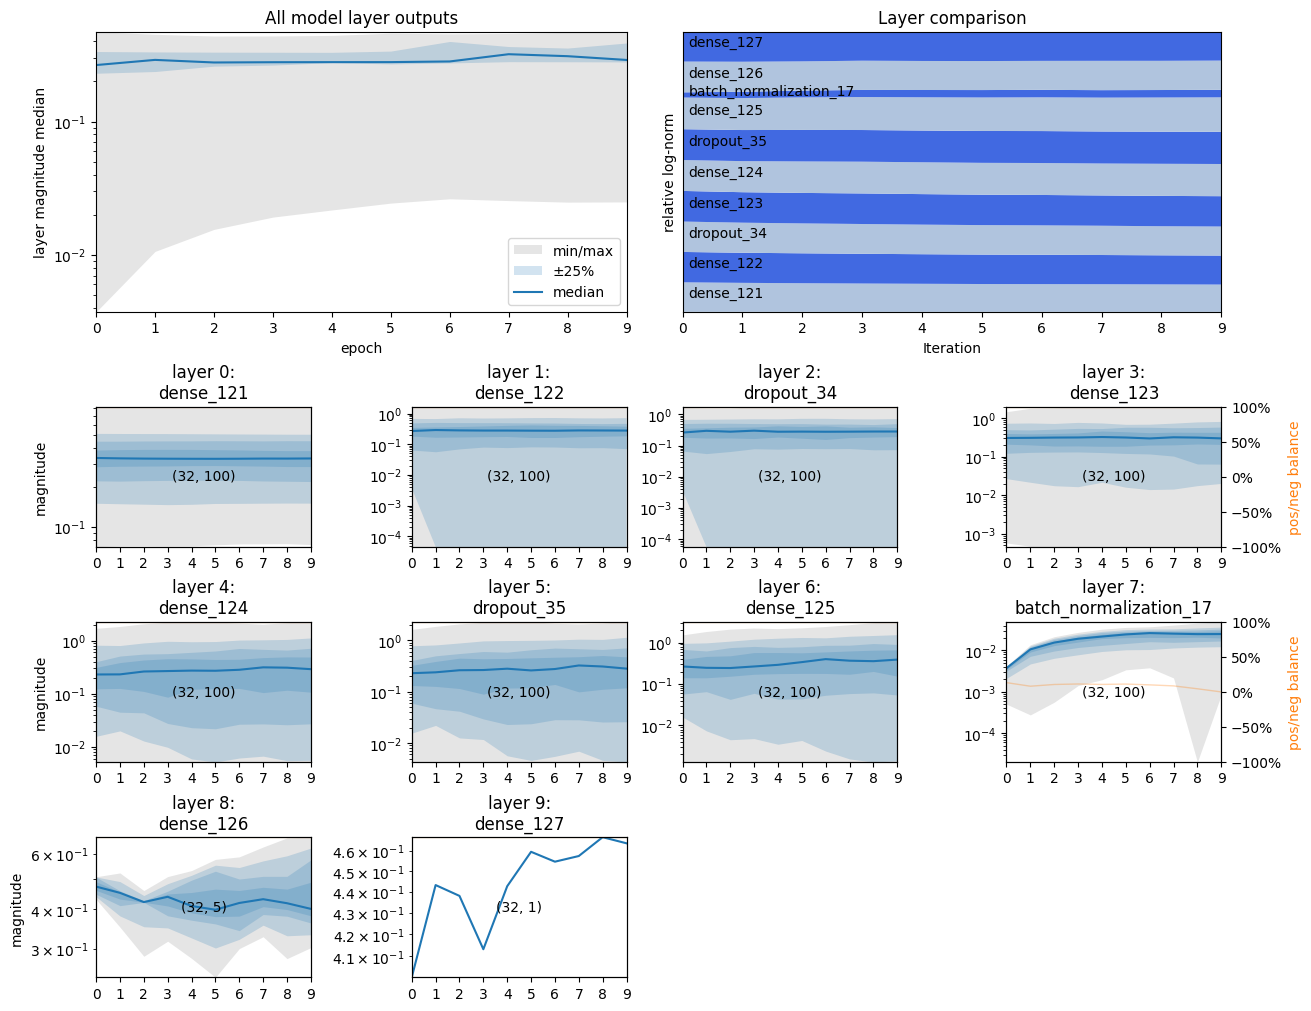

In [150]:
tot.plot_value_history(epoch_outputs, show='magnitudes')

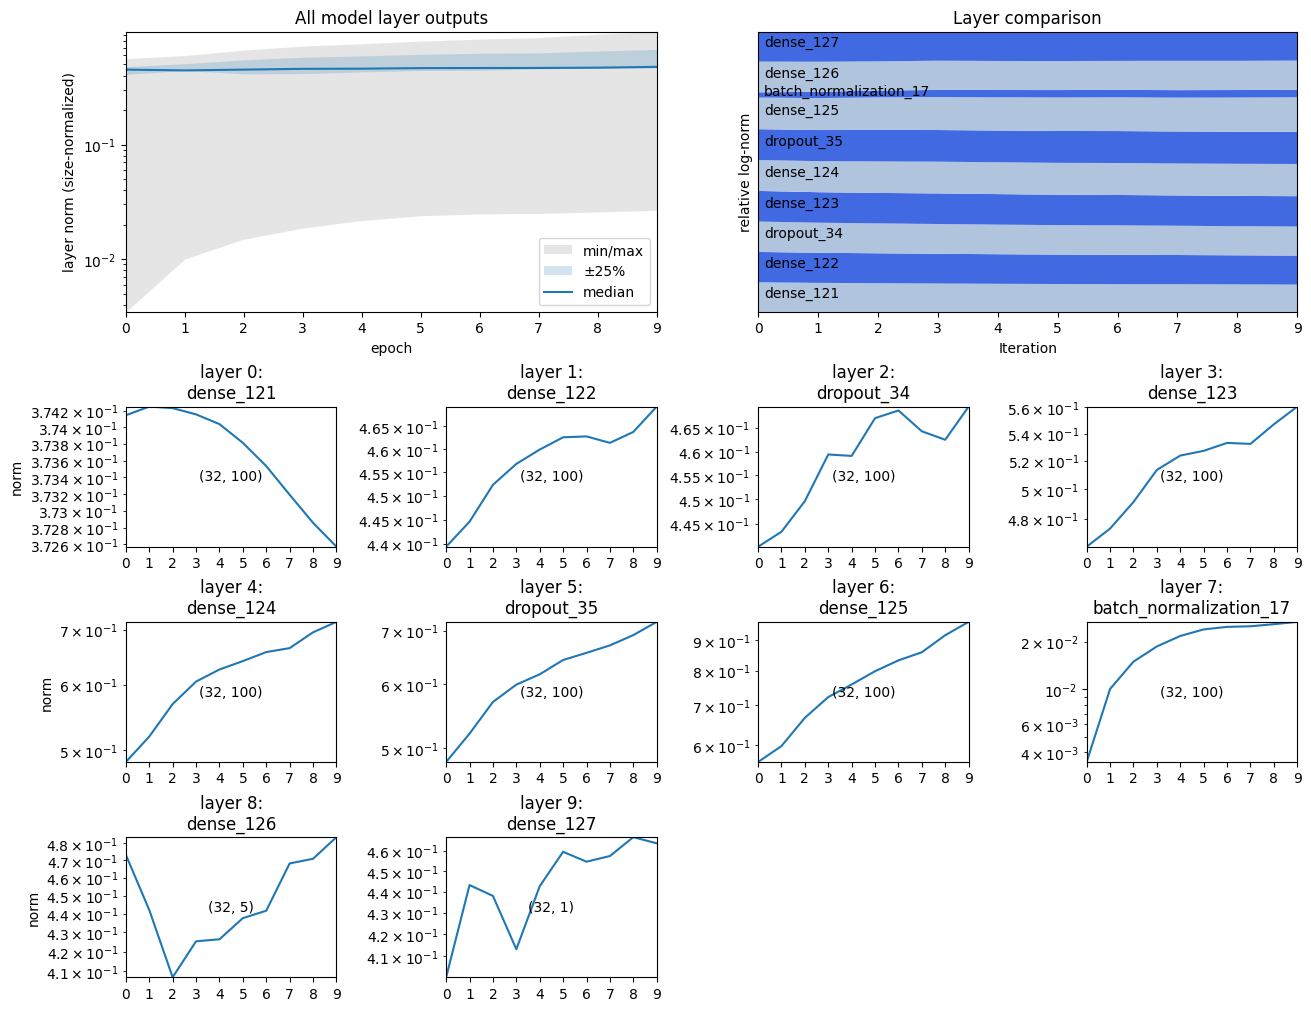

In [151]:
tot.plot_value_history(epoch_outputs, show='norms')

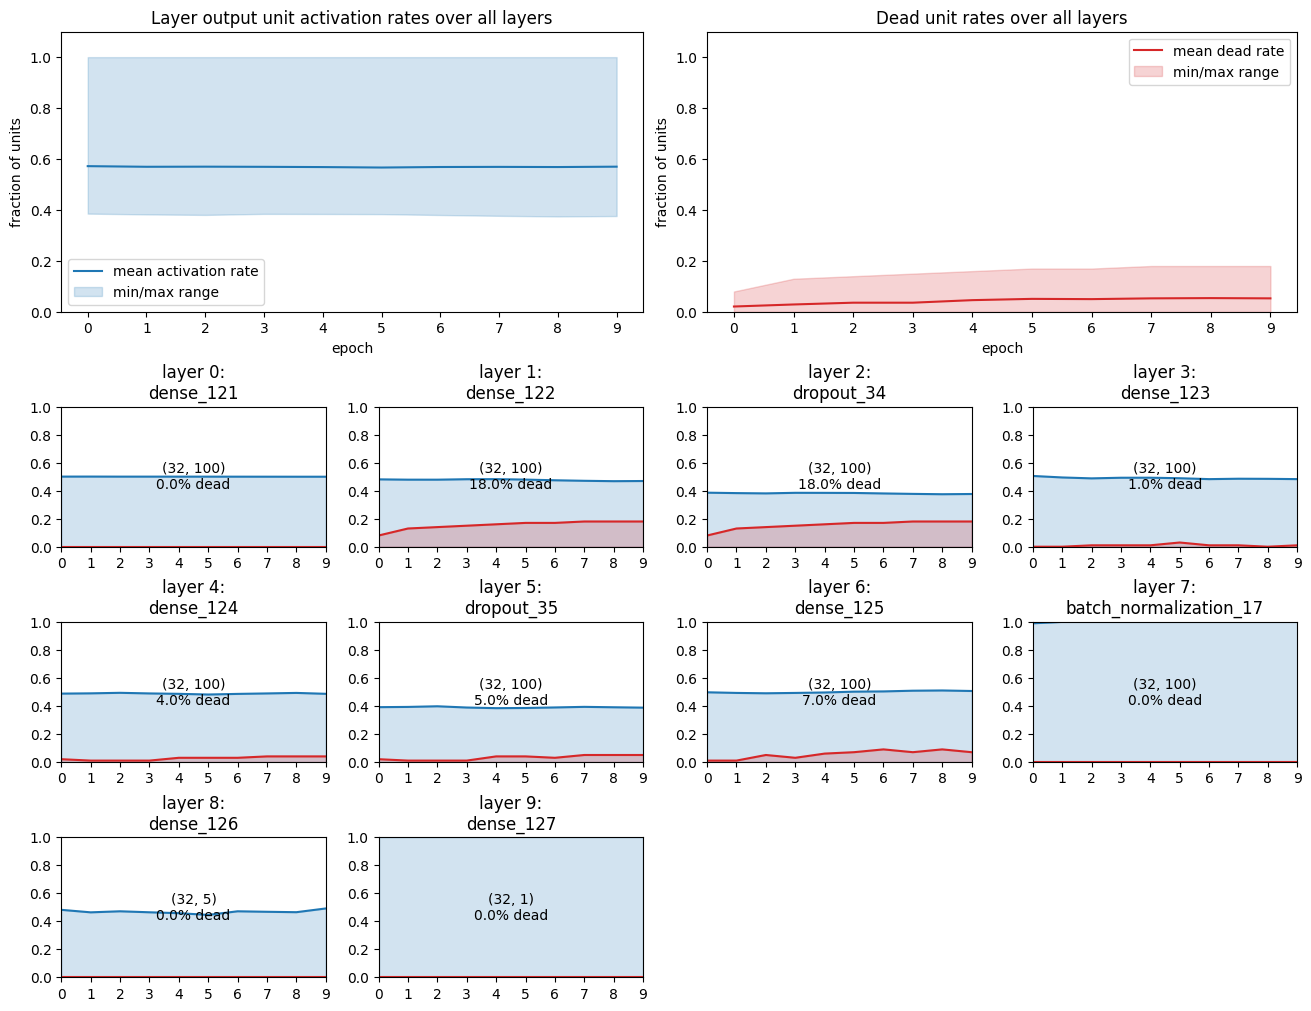

In [152]:
tot.plot_activity_history(epoch_outputs)

## Final thoughts
Using norms instead of estimated magnitude means didn't make much difference. Technically this the difference between L2-norms and L1-norms, with the added advantage of directly calculating the L2-norms instead of _estimating_ the L1-norms.

In practice, the difference turned out to be small. The layer comparisons plot is a little smoother - which is nice. And it's interesting that it kept some spikyness while losing others, suggesting that there are times when it goes spiky and we want to see those times.

In any case, having the norms is more consistent with what scientifit literature uses, so I'll be on better ground when writing about this.